In [1]:
# 20170422 update
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## def(td,ff,px): # where td is dataframe, ff & px are column names of failflag and probdefault
def auc(td,ff,px):
  pn = td[td[ff]==0][[px,ff]]
  py = td[td[ff]==1][[px,ff]]
  pn.reset_index(drop=True, inplace=True)
  py.reset_index(drop=True, inplace=True)

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list
  cs = 0  # count successes

  for j in np.arange(ly):
    x = ( pn[px] < py.ix[j][px] )*1
    cs = cs + sum(x)

  r = float(cs) / float(ln * ly)  # area under curve
  return r  ## .982024 in excel

In [3]:
## make ctlst (cutlist) of 73 points spaced for good charts:
ctlst2 = list(np.arange(0,2,.1)) + list(np.arange(2,5,.5)) + list(np.arange(5,15,1)) + list(np.arange(15,90,5))
ctlst2 = ctlst2 + list(np.arange(90,97,1)) + list(np.arange(97,99,.5)) + list(np.arange(99,100,.1)) + [100]
#ctlst = [np.round(x,1) for x in ctlst]
ctlst = [np.round(float(x)/100,3) for x in ctlst2]
ctlst[40:50]

[0.34999999999999998,
 0.40000000000000002,
 0.45000000000000001,
 0.5,
 0.55000000000000004,
 0.59999999999999998,
 0.65000000000000002,
 0.69999999999999996,
 0.75,
 0.80000000000000004]

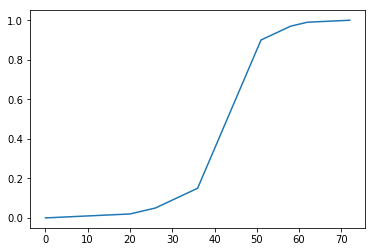

In [4]:
plt.plot(np.arange(len(ctlst)),ctlst)

In [5]:
## function for roc points (ctlst: 73 cuts) (1.1 sec to solve):
def roc(td,ff,px,ct):
  pn = td[td[ff]==0][[px,ff]]
  py = td[td[ff]==1][[px,ff]]

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list

  xm = pd.DataFrame(columns=['cut','fail', 'surv', 'sens', 'spec', 'FPR'],dtype='float')

  for i in np.arange(len(ct)):
    x1 = ct[i]
    x2 = sum((py[px] > x1)*1)
    x3 = sum((pn[px] > x1)*1)
    x4 = float(x2)/float(ly)
    x5 = float(ln - x3)/float(ln)
    x6 = 1 - x5
    xm=xm.append({'cut':x1,'fail':x2,'surv':x3,'sens':x4,'spec':x5,'FPR':x6},ignore_index=True)

  return xm

In [6]:
### read in all bank data with ratios to run ROC analyses:
dff = pd.read_csv("allbanks_f2468_roe0mm2_20091231.csv",index_col=0)
dff['AsOf'] = pd.to_datetime(dff['AsOf'])
dff['FailDate'] = pd.to_datetime(dff['FailDate'])
dff.head()

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   
2      37 2002-06-30  BANK OF HANCOCK COUNTY    GA  69304.0  0.364757   
3      37 2002-09-30  BANK OF HANCOCK COUNTY    GA  71970.0  0.495989   
4      37 2002-12-31  BANK OF HANCOCK COUNTY    GA  74327.0  0.610962   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385    ...      0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604    ...      0   0   0        1.0   
2  0.206747  4.599485  1.927457  1.294383    ...      0   0   0        1.0   
3  0.325492  4.492631  1.833764  1.235163    ...      0   0   0        1.0   
4  0.268236  4.436347  1.816232  1.214158    ...      0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  1.816980e-08  2.457995e-08  2.658786e-07  1.808432e-08  3.640110e-07   
1  2.074132e-08  2.819496e-08  2.984160e-07  2.111511e-08  4.128278e-07   
2  2.624992e-08  3.539017e-08  3.656513e-07  2.750531e-08  5.105488e-07   
3  4.456546e-08  5.939042e-08  5.798267e-07  5.008500e-08  8.313529e-07   
4  1.606111e-08  2.269976e-08  2.410813e-07  1.621047e-08  3.368549e-07   

       f6_5  
0  0.000002  
1  0.000002  
2  0.000003  
3  0.000004  
4  0.000002  

[5 rows x 33 columns]

In [7]:
prm0 = pd.read_csv("f246_params_roe0mm2_2009.csv",index_col=0)
#prm225 = pd.read_csv("f246_params_alt225mm_2009.csv",index_col=0)

In [8]:
prm0

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

In [9]:
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
xcol

['rcTotLn',
 'qnTotLn',
 'rNIM',
 'rPPNR',
 'rROA',
 'rROE',
 'rEff',
 'eLn_Dep',
 'aFF_TA',
 'eBrok_Dep',
 'eT1rb',
 'eTotrb',
 'eALLL_Ln',
 'lnTotAst']

In [10]:
fcol = [x for x in list(dff.columns) if x[0:1]=='f']
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [11]:
targ = pd.to_datetime('2009-12-31')
thresh = 0 ## no minimum size threshold (not needed)
alt = '' ## or alt = ''
dfh = dff[(dff['AsOf']<=targ)&(dff['eTotAst']>(thresh*1000))]\
      [['IDRSSD','AsOf','Name','FailDate']+xcol+fcol]
#dfr09 = sm.add_constant(dfr09)
len(dfh), len(dff) # 259210, 444470

(259210, 444470)

In [12]:
dfh[xcol].max()

rcTotLn      3.543633e+03
qnTotLn      1.000000e+02
rNIM         4.160000e+04
rPPNR        5.272914e+02
rROA         3.423426e+02
rROE         5.877828e+02
rEff         5.480120e+07
eLn_Dep      9.934150e+02
aFF_TA       1.534201e+02
eBrok_Dep    1.000000e+02
eT1rb        1.999829e+02
eTotrb       2.268312e+02
eALLL_Ln     1.000000e+02
lnTotAst     2.129349e+01
dtype: float64

In [13]:
dfh[xcol].min()

rcTotLn     -5.000000e-01
qnTotLn      0.000000e+00
rNIM        -1.360000e+04
rPPNR       -6.429146e+01
rROA        -7.697304e+01
rROE        -1.998472e+02
rEff        -3.359000e+08
eLn_Dep      0.000000e+00
aFF_TA      -2.722560e+02
eBrok_Dep    0.000000e+00
eT1rb        0.000000e+00
eTotrb       0.000000e+00
eALLL_Ln     0.000000e+00
lnTotAst     6.486161e+00
dtype: float64

In [14]:
## screening criteria:
dfh.dropna(how='any',inplace=True,subset=dfh.columns[8:])  # delete any ratio columns with NaN values (note columns[8:])
dfh= dfh[dfh['eLn_Dep']<=1000]
dfh= dfh[dfh['eBrok_Dep']<=100]
dfh= dfh[dfh['eALLL_Ln']<=100]
dfh= dfh[dfh['rROE']>=-200]
dfh= dfh[dfh['lnTotAst']>2]
dfh= dfh[dfh['eT1rb']<=200]
len(dfh)

259210

In [15]:
## set fflags to zero if FailDate after targ2 date (12/31/2010); that is, for f4
## increment date by interval:
targ2 = targ+timedelta(days=365)
dfh.ix[dfh.FailDate>targ2,['f2','f4','f6','f8']] = [0,0,0,0]
targ2

Timestamp('2010-12-31 00:00:00')

In [16]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2011-03-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head(8)

IDRSSD       AsOf                   Name   FailDate  f2  f4  f6  f8
5236    16337 2009-09-30           WAKULLA BANK 2010-10-01   0   0   1   1
5237    16337 2009-12-31           WAKULLA BANK 2010-10-01   0   1   1   1
14067   41647 2009-09-30   FIRST BANKING CENTER 2010-11-19   0   0   1   1
14068   41647 2009-12-31   FIRST BANKING CENTER 2010-11-19   0   1   1   1
18779   54357 2009-09-30  FIRST STATE BANK, THE 2011-01-28   0   0   0   0
18780   54357 2009-12-31  FIRST STATE BANK, THE 2011-01-28   0   0   0   0
40865  117841 2009-09-30   EVERGREEN STATE BANK 2011-01-28   0   0   0   0
40866  117841 2009-12-31   EVERGREEN STATE BANK 2011-01-28   0   0   0   0

In [17]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2012-01-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head()

IDRSSD       AsOf                 Name   FailDate  f2  f4  f6  f8
5236   16337 2009-09-30         WAKULLA BANK 2010-10-01   0   0   1   1
5237   16337 2009-12-31         WAKULLA BANK 2010-10-01   0   1   1   1
6751   20370 2009-09-30  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
6752   20370 2009-12-31  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
7842   23241 2009-09-30      INTEGRA BANK NA 2011-07-29   0   0   0   0

In [18]:
dff.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8', 'Intercept', 'f2_0', 'f2_1',
       'f4_2', 'f4_3', 'f6_4', 'f6_5'],
      dtype='object')

In [19]:
dfh.columns

Index(['IDRSSD', 'AsOf', 'Name', 'FailDate', 'rcTotLn', 'qnTotLn', 'rNIM',
       'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA', 'eBrok_Dep',
       'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'f2', 'f4', 'f6', 'f8',
       'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5'],
      dtype='object')

In [20]:
### generate forecasts for all 4-var models:
dv4 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4 = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])

for idx, row in prm0.iterrows():
  fv = row['fx']
  x = idx
  eqnc = fv + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
  res = sm.Logit(yc, Xc).fit()
  dv4 = dv4.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                    'v3':row['v3'],'r3': row['r3'], 'v4':row['v4'],'r4': res.prsquared},ignore_index=True)
  cm = pd.DataFrame(res.params).T
  cm.columns = ['Int','c1','c2','c3','c4']
  cm['idx'] = idx
  cm['v4'] = row['v4']
  cv4 = cv4.append(cm.ix[0])
  pred_tot = res.predict(Xc)
  dfh[fv+'_'+str(x)+'rr'] = pred_tot
  p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
  dff[fv+'_'+str(x)+'rr'] = p_tot

cv4 = cv4.reset_index(drop=True)
dv4 = dv4.reset_index(drop=True)
dv4 = dv4.merge(cv4, how='inner', on=['idx','v4'])


Optimization terminated successfully.
         Current function value: 0.004026
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004090
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.010472
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010502
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.018770
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.018829
         Iterations 12


In [21]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  1.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  5.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

In [22]:
prm0

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

In [23]:
dv4.to_csv("modelrerun_f246_params_roe0mm2_2009.csv")

In [24]:
fcolrr = [x for x in list(dff.columns) if x[0:1]=='f']
fcolrr

['f2',
 'f4',
 'f6',
 'f8',
 'f2_0',
 'f2_1',
 'f4_2',
 'f4_3',
 'f6_4',
 'f6_5',
 'f2_0rr',
 'f2_1rr',
 'f4_2rr',
 'f4_3rr',
 'f6_4rr',
 'f6_5rr']

In [25]:
dffsum=dff[['AsOf']+fcolrr].groupby('AsOf').sum()
dffsum.ix['2009':'2010']

f2   f4   f6   f8       f2_0       f2_1        f4_2        f4_3  \
AsOf                                                                          
2009-03-31  55  127  197  248  39.917977  38.468347   91.283776   92.637105   
2009-06-30  59  131  189  232  49.093167  50.077017  109.054071  107.127208   
2009-09-30  52  119  170  213  48.977391  50.292186  113.122369  109.162461   
2009-12-31  62  120  163  204  73.303020  74.859571  150.570430  146.923207   
2010-03-31  53  104  146  177  70.684623  74.628322  140.236146  127.106464   
2010-06-30  43   86  127  151  58.258775  63.955999  117.360695  101.415872   
2010-09-30  36   78  108  127  52.636542  58.346461  105.980154   88.228785   
2010-12-31  34   75   99  115  52.011692  56.621807  105.626960   94.501162   

                  f6_4        f6_5     f2_0rr     f2_1rr      f4_2rr  \
AsOf                                                                   
2009-03-31  136.599773  133.968930  39.917977  38.468347   91.283776   
2009-06-30  154.836742  155.632097  49.093167  50.077017  109.054071   
2009-09-30  160.757197  164.020046  48.977391  50.292186  113.122369   
2009-12-31  197.169234  201.215898  73.303020  74.859571  150.570430   
2010-03-31  172.491030  185.328841  70.684623  74.628322  140.236146   
2010-06-30  142.563520  158.598685  58.258775  63.955999  117.360695   
2010-09-30  125.258839  144.161403  52.636542  58.346461  105.980154   
2010-12-31  129.588281  142.706136  52.011692  56.621807  105.626960   

                f4_3rr      f6_4rr      f6_5rr  
AsOf                                            
2009-03-31   92.637105  136.599773  133.968930  
2009-06-30  107.127208  154.836742  155.632097  
2009-09-30  109.162461  160.757197  164.020046  
2009-12-31  146.923207  197.169234  201.215898  
2010-03-31  127.106464  172.491030  185.328841  
2010-06-30  101.415872  142.563520  158.598685  
2010-09-30   88.228785  125.258839  144.161403  
2010-12-31   94.501162  129.588281  142.706136

In [26]:
## single variable models for all fx:
dvv = pd.DataFrame(columns=['fx','v1', 'r1'])
cvv = pd.DataFrame(columns=['fx','v1','Int','c1'])

vr=prm0[['v1','v2','v3','v4']].values
vrlst = list(set(e for r in vr for e in r))  ## list of unique variables among coefficients
vrlst = vrlst + ['eLn_Dep','aFF_TA']

for x in vrlst:
  for y in ['f2','f4','f6']:
    eqnc = y + " ~ " + x  # regression eqn
    pvar = ["Intercept", x]  # var for predictions
    yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
    res = sm.Logit(yc, Xc).fit()
    dvv = dvv.append({'fx':y,'v1':x,'r1':res.prsquared},ignore_index=True)
    cm = pd.DataFrame(res.params).T
    cm.columns = ['Int','c1']
    cm['fx'] = y
    cm['v1'] = x
    cvv = cvv.append(cm)
    pred_tot = res.predict(Xc)
    dfh[y+'_'+x] = pred_tot
    p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
    dff[y+'_'+x] = p_tot

cvv = cvv.reset_index(drop=True)
dvv = dvv.reset_index(drop=True)
dvv = dvv.merge(cvv, how='inner', on=['fx','v1'])

Optimization terminated successfully.
         Current function value: 0.008902
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.019490
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030266
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.004956
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.013809
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.024610
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009019
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.018136
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027559
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.0

In [27]:
dvv

fx         v1        r1        Int        c1
0   f2       rROA  0.141832  -6.641635 -0.284352
1   f4       rROA  0.152501  -5.698739 -0.347297
2   f6       rROA  0.129511  -5.157361 -0.353485
3   f2      eT1rb  0.522181   2.809685 -0.969876
4   f4      eT1rb  0.399541   3.640299 -0.907987
5   f6      eT1rb  0.292186   2.943719 -0.757253
6   f2    qnTotLn  0.130563  -6.986268  0.164781
7   f4    qnTotLn  0.211410  -6.378276  0.272325
8   f6    qnTotLn  0.207348  -5.908558  0.297713
9   f2  eBrok_Dep  0.056154  -6.927195  0.041727
10  f4  eBrok_Dep  0.066877  -6.009661  0.042884
11  f6  eBrok_Dep  0.074322  -5.526108  0.043971
12  f2   lnTotAst  0.028233 -11.176789  0.374696
13  f4   lnTotAst  0.030360 -10.167129  0.368479
14  f6   lnTotAst  0.032131  -9.661138  0.367514
15  f2       rROE  0.488963  -7.356215 -0.056348
16  f4       rROE  0.397054  -6.082230 -0.059862
17  f6       rROE  0.300326  -5.347565 -0.057496
18  f2    eLn_Dep  0.001881  -6.884747  0.003556
19  f4    eLn_Dep  0.003798  -6.013038  0.004215
20  f6    eLn_Dep  0.006362  -5.573603  0.004813
21  f2     aFF_TA  0.002738  -6.700089  0.019721
22  f4     aFF_TA  0.000844  -5.720939  0.011124
23  f6     aFF_TA  0.000002  -5.171728 -0.000568

In [28]:
dvv.to_csv("SingleVar_params_roe0mm2_2009.csv")

In [29]:
dff.to_csv("allbanks_f2468_roe0mm2_20091231_singles.csv")
dfh.to_csv("modelbanks_f2468_roe0mm2_2009_singles.csv")

In [30]:
fcol = [x for x in list(dff.columns) if x[0]=='f']
fcol[10:26]

['f2_0rr',
 'f2_1rr',
 'f4_2rr',
 'f4_3rr',
 'f6_4rr',
 'f6_5rr',
 'f2_rROA',
 'f4_rROA',
 'f6_rROA',
 'f2_eT1rb',
 'f4_eT1rb',
 'f6_eT1rb',
 'f2_qnTotLn',
 'f4_qnTotLn',
 'f6_qnTotLn',
 'f2_eBrok_Dep']

In [31]:
fnbr = dff[['AsOf']+fcol[0:5]+fcol[10:16]].groupby('AsOf').sum()
fnbr['2009':'2011']

f2   f4   f6   f8       f2_0     f2_0rr     f2_1rr      f4_2rr  \
AsOf                                                                         
2009-03-31  55  127  197  248  39.917977  39.917977  38.468347   91.283776   
2009-06-30  59  131  189  232  49.093167  49.093167  50.077017  109.054071   
2009-09-30  52  119  170  213  48.977391  48.977391  50.292186  113.122369   
2009-12-31  62  120  163  204  73.303020  73.303020  74.859571  150.570430   
2010-03-31  53  104  146  177  70.684623  70.684623  74.628322  140.236146   
2010-06-30  43   86  127  151  58.258775  58.258775  63.955999  117.360695   
2010-09-30  36   78  108  127  52.636542  52.636542  58.346461  105.980154   
2010-12-31  34   75   99  115  52.011692  52.011692  56.621807  105.626960   
2011-03-31  32   62   83   93  46.254642  46.254642  51.298766   93.504836   
2011-06-30  25   48   63   74  37.409714  37.409714  42.206782   79.032753   
2011-09-30  19   38   48   60  35.141336  35.141336  40.007353   72.359158   
2011-12-31  18   34   46   54  31.029955  31.029955  34.980722   64.146970   

                f4_3rr      f6_4rr      f6_5rr  
AsOf                                            
2009-03-31   92.637105  136.599773  133.968930  
2009-06-30  107.127208  154.836742  155.632097  
2009-09-30  109.162461  160.757197  164.020046  
2009-12-31  146.923207  197.169234  201.215898  
2010-03-31  127.106464  172.491030  185.328841  
2010-06-30  101.415872  142.563520  158.598685  
2010-09-30   88.228785  125.258839  144.161403  
2010-12-31   94.501162  129.588281  142.706136  
2011-03-31   79.326055  110.559027  126.062120  
2011-06-30   64.160244   92.240709  109.009684  
2011-09-30   58.094807   82.674139   98.803007  
2011-12-31   55.857955   78.144187   88.696563

In [32]:
dffg = dff[dff['AsOf']>'2009-01-01'][['AsOf']+fcol]

In [33]:
len(dffg) # 165272

214485

In [34]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
454780 2016-09-30   0   0   0   0  6.245865e-11  1.221664e-10  2.272020e-09   
454781 2016-12-31   0   0   0   0  6.240875e-09  1.053034e-08  1.175688e-07   

                f4_3          f6_4    ...      f6_lnTotAst   f2_rROE  \
454780  1.524872e-10  1.037877e-08    ...         0.003850  0.001036   
454781  1.665627e-08  4.160919e-07    ...         0.004208  0.000996   

         f4_rROE   f6_rROE  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  f2_aFF_TA  \
454780  0.003808  0.007748    0.001570    0.004053    0.006743   0.002157   
454781  0.003651  0.007442    0.001474    0.003763    0.006196   0.001950   

        f4_aFF_TA  f6_aFF_TA  
454780   0.004481   0.005553  
454781   0.004235   0.005569  

[2 rows x 41 columns]

In [35]:
dffg[['f4','f6']].groupby('f4').count()

f6
f4        
0   213230
1     1255

In [36]:
dff[['f4','f6']].groupby('f4').count()

f6
f4        
0   442818
1     1652

In [37]:
%time xc = roc(dffg, 'f4', 'f4_2', ctlst)

Wall time: 1.22 s


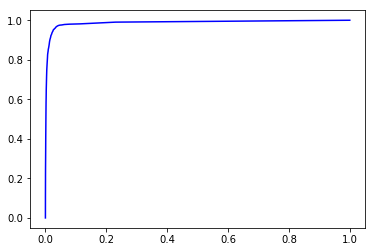

In [38]:
plt.plot(xc['FPR'],xc['sens'],c='b')

In [39]:
def auc(td,ff,px):
  pn = td[td[ff]==0][[px,ff]]
  pn.reset_index(drop=True, inplace=True)
  py = td[td[ff]==1][[px,ff]]
  py.reset_index(drop=True, inplace=True)

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list
  cs = 0  # count successes

  for j in np.arange(ly):
    x = ( pn[px] < py.ix[j][px] )*1
    cs = cs + sum(x)

  r = float(cs) / float(ln * ly)  # area under curve
  return r  ## .982024 in excel

%time x = auc(dffg, 'f4', 'f4_2rr')

Wall time: 17.9 s


In [40]:
x

0.9888899646921856

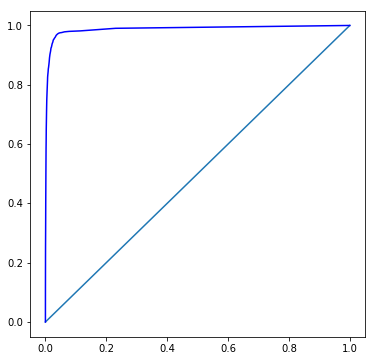

In [41]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot([0,1],[0,1])
plt.plot(xc['FPR'],xc['sens'],c='b')
plt.show()

In [42]:
f4lst=[x for x in list(dffg.columns) if x[0:2]=='f4']  ## all f4 columns
fxlst= [x for x in f4lst if x not in ['f4','f4_2','f4_3','f4_aFF_TA']]  ## no f4; only vars used in models plus 2 dummy vars
f4lst, fxlst

(['f4',
  'f4_2',
  'f4_3',
  'f4_2rr',
  'f4_3rr',
  'f4_rROA',
  'f4_eT1rb',
  'f4_qnTotLn',
  'f4_eBrok_Dep',
  'f4_lnTotAst',
  'f4_rROE',
  'f4_eLn_Dep',
  'f4_aFF_TA'],
 ['f4_2rr',
  'f4_3rr',
  'f4_rROA',
  'f4_eT1rb',
  'f4_qnTotLn',
  'f4_eBrok_Dep',
  'f4_lnTotAst',
  'f4_rROE',
  'f4_eLn_Dep'])

In [43]:
f4auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in fxlst:
  y = auc(dffg, 'f4', x)
  f4auc=f4auc.append({'modvar':x,'auc':y, 'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f4_2rr
f4_3rr
f4_rROA
f4_eT1rb
f4_qnTotLn
f4_eBrok_Dep
f4_lnTotAst
f4_rROE
f4_eLn_Dep


In [44]:
f4auc['aucs'] = f4auc.apply(lambda x: str(np.round(x['auc']*100,1)),axis=1)
f4auc

modvar       auc  aucs
0        f4_2rr  0.988890  98.9
1        f4_3rr  0.988612  98.9
2       f4_rROA  0.970274  97.0
3      f4_eT1rb  0.979904  98.0
4    f4_qnTotLn  0.956015  95.6
5  f4_eBrok_Dep  0.615228  61.5
6   f4_lnTotAst  0.552859  55.3
7       f4_rROE  0.978271  97.8
8    f4_eLn_Dep  0.552187  55.2

In [45]:
f4auc.to_csv("f4auc_roe0mm2_20091231.csv")

In [46]:
f6lst0=[x for x in list(dffg.columns) if x[0:2]=='f6']  ## all f4 columns
f6lst= [x for x in f6lst0 if x not in ['f6','f6_4','f6_5','f6_aFF_TA']] 
f6lst

['f6_4rr',
 'f6_5rr',
 'f6_rROA',
 'f6_eT1rb',
 'f6_qnTotLn',
 'f6_eBrok_Dep',
 'f6_lnTotAst',
 'f6_rROE',
 'f6_eLn_Dep']

In [47]:
f6auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f6lst:
  y = auc(dffg, 'f6', x)
  f6auc=f6auc.append({'modvar':x,'auc':y,'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f6_4rr
f6_5rr
f6_rROA
f6_eT1rb
f6_qnTotLn
f6_eBrok_Dep
f6_lnTotAst
f6_rROE
f6_eLn_Dep


In [48]:
f2lst0=[x for x in list(dffg.columns) if x[0:2]=='f2']  ## all f4 columns
f2lst= [x for x in f2lst0 if x not in ['f2','f2_0','f2_1','f2_aFF_TA']] 
f2lst

['f2_0rr',
 'f2_1rr',
 'f2_rROA',
 'f2_eT1rb',
 'f2_qnTotLn',
 'f2_eBrok_Dep',
 'f2_lnTotAst',
 'f2_rROE',
 'f2_eLn_Dep']

In [49]:
f2auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f2lst:
  y = auc(dffg, 'f2', x)
  f2auc=f2auc.append({'modvar':x,'auc':y,'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f2_0rr
f2_1rr
f2_rROA
f2_eT1rb
f2_qnTotLn
f2_eBrok_Dep
f2_lnTotAst
f2_rROE
f2_eLn_Dep


In [50]:
f2auc

modvar       auc  aucs
0        f2_0rr  0.991557  99.2
1        f2_1rr  0.989422  98.9
2       f2_rROA  0.973334  97.3
3      f2_eT1rb  0.986598  98.7
4    f2_qnTotLn  0.960705  96.1
5  f2_eBrok_Dep  0.590342  59.0
6   f2_lnTotAst  0.548813  54.9
7       f2_rROE  0.982233  98.2
8    f2_eLn_Dep  0.525844  52.6

In [51]:
f2auc.to_csv("f2auc_roe0mm2_20091231.csv")

In [52]:
f6auc.to_csv("f6auc_roe0mm2_20091231.csv")

In [53]:
f6auc

modvar       auc  aucs
0        f6_4rr  0.986185  98.6
1        f6_5rr  0.986366  98.6
2       f6_rROA  0.964177  96.4
3      f6_eT1rb  0.971708  97.2
4    f6_qnTotLn  0.949368  94.9
5  f6_eBrok_Dep  0.626945  62.7
6   f6_lnTotAst  0.554000  55.4
7       f6_rROE  0.970605  97.1
8    f6_eLn_Dep  0.570426  57.0

In [54]:
%time y = roc(dffg, 'f4', 'f4_2rr',ctlst)

Wall time: 1.22 s


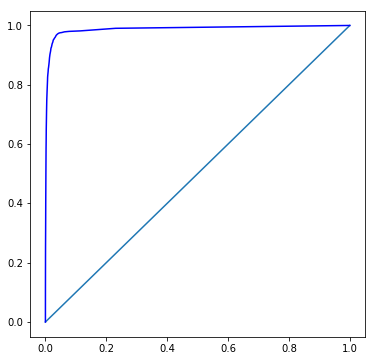

In [55]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot([0,1],[0,1])
plt.plot(y['FPR'],y['sens'],c='b')
plt.show()

In [56]:
#f4roc:
for i in np.arange(len(fxlst)):
#for i in np.arange(2):
  v = fxlst[i]
  y = roc(dffg, 'f4', v, ctlst)
  if i == 0:
    f4roc = y[['cut','sens','FPR']]
    f4roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f4roc = f4roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f4roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f4roc.to_csv("f4rocpts_roe0mm2_2009.csv")
f4roc.head()    

cut  f4_2rr_sens  f4_2rr_FPR  f4_3rr_sens  f4_3rr_FPR  f4_rROA_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000      1.000000   
1  0.001     0.990438    0.230727     0.988845    0.199442      1.000000   
2  0.002     0.981673    0.114097     0.981673    0.108005      0.996016   
3  0.003     0.980080    0.078211     0.978486    0.075820      0.982470   
4  0.004     0.978486    0.062332     0.976892    0.061033      0.962550   

   f4_rROA_FPR  f4_eT1rb_sens  f4_eT1rb_FPR  f4_qnTotLn_sens  f4_qnTotLn_FPR  \
0     1.000000       1.000000      1.000000         1.000000        1.000000   
1     0.990166       0.974502      0.194982         1.000000        1.000000   
2     0.863439       0.968127      0.123899         0.989641        0.613286   
3     0.234493       0.962550      0.089922         0.967331        0.277911   
4     0.090846       0.957769      0.069615         0.945817        0.174708   

   f4_eBrok_Dep_sens  f4_eBrok_Dep_FPR  f4_lnTotAst_sens  f4_lnTotAst_FPR  \
0           1.000000          1.000000          1.000000         1.000000   
1           1.000000          1.000000          1.000000         0.998091   
2           1.000000          1.000000          0.919522         0.888646   
3           0.497211          0.198284          0.654980         0.563593   
4           0.314741          0.087961          0.361753         0.305811   

   f4_rROE_sens  f4_rROE_FPR  f4_eLn_Dep_sens  f4_eLn_Dep_FPR  
0      1.000000     1.000000         1.000000        1.000000  
1      0.993625     0.864522         1.000000        1.000000  
2      0.980080     0.208845         1.000000        1.000000  
3      0.969721     0.094386         0.972908        0.881977  
4      0.964143     0.067753         0.008765        0.015617

In [57]:
######### CAUTION ############################################
# shortcut to skip earlier processing and get to charts below
##############################################################

## read auc files:
#f2auc= pd.read_csv("f2auc_roe0mm2_20091231.csv",index_col=0)
#f4auc= pd.read_csv("f4auc_roe0mm2_20091231.csv",index_col=0)
#f6auc= pd.read_csv("f6auc_roe0mm2_20091231.csv",index_col=0)
#f2auc['aucs'] = f2auc['aucs'].astype(str)
#f4auc['aucs'] = f4auc['aucs'].astype(str)
#f6auc['aucs'] = f6auc['aucs'].astype(str)

## read roc files:
#f2roc= pd.read_csv("f2rocpts_roe0mm2_2009.csv",index_col=0)
#f4roc= pd.read_csv("f4rocpts_roe0mm2_2009.csv",index_col=0)
#f6roc= pd.read_csv("f6rocpts_roe0mm2_2009.csv",index_col=0)

In [58]:
f2auc.dtypes

modvar     object
auc       float64
aucs       object
dtype: object

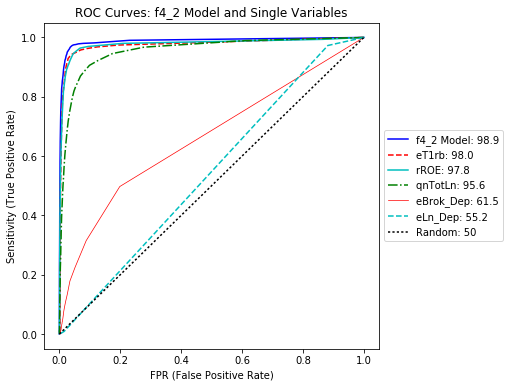

In [59]:
## Code to resize chart frame !!!!!!
#f4auc['aucs'] = f4auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f4auc['modvar'],f4auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f4roc['f4_2rr_FPR'],f4roc['f4_2rr_sens'],c='b',lw=1.5,label='f4_2 Model: '+dauc['f4_2rr'])
#plt.plot(f4roc['f4_3rr_FPR'],f4roc['f4_3rr_sens'],c='b',ls='--',label='f4 Model2: '+dauc['f4_3rr'])
plt.plot(f4roc['f4_eT1rb_FPR'],f4roc['f4_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f4_eT1rb'])
#plt.plot(f4roc['f4_rROA_FPR'],f4roc['f4_rROA_sens'],c='c',ls='--',label='rROA: '+dauc['f4_rROA'])
plt.plot(f4roc['f4_rROE_FPR'],f4roc['f4_rROE_sens'],c='c',label='rROE: '+dauc['f4_rROE'])
plt.plot(f4roc['f4_qnTotLn_FPR'],f4roc['f4_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f4_qnTotLn'])
plt.plot(f4roc['f4_eBrok_Dep_FPR'],f4roc['f4_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f4_eBrok_Dep'])
plt.plot(f4roc['f4_eLn_Dep_FPR'],f4roc['f4_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f4_eLn_Dep'])
#plt.plot(f4roc['f4_aFF_TA_FPR'],f4roc['f4_aFF_TA_sens'],c='g',ls='--',label='aFF_TA: '+dauc['f4_aFF_TA'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f4_2 Model and Single Variables')
plt.savefig('ROC_f4_roe0mm2_2009.png', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
#f6roc:
for i in np.arange(len(f6lst)):
#for i in np.arange(2):
  v = f6lst[i]
  y = roc(dffg, 'f6', v, ctlst)
  if i == 0:
    f6roc = y[['cut','sens','FPR']]
    f6roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f6roc = f6roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f6roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f6roc.to_csv("f6rocpts_roe0mm2_2009.csv")
f6roc.head()    

cut  f6_4rr_sens  f6_4rr_FPR  f6_5rr_sens  f6_5rr_FPR  f6_rROA_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000      1.000000   
1  0.001     0.995444    0.401384     0.995444    0.457916      1.000000   
2  0.002     0.988610    0.251705     0.991458    0.281649      1.000000   
3  0.003     0.988041    0.174114     0.986333    0.186768      0.996014   
4  0.004     0.981207    0.129968     0.982346    0.135684      0.989749   

   f6_rROA_FPR  f6_eT1rb_sens  f6_eT1rb_FPR  f6_qnTotLn_sens  f6_qnTotLn_FPR  \
0     1.000000       1.000000      1.000000         1.000000        1.000000   
1     0.993503       0.976082      0.337693         1.000000        1.000000   
2     0.987261       0.968109      0.241702         1.000000        1.000000   
3     0.932717       0.960137      0.187252         0.988610        0.712404   
4     0.664747       0.956150      0.150497         0.974374        0.412436   

   f6_eBrok_Dep_sens  f6_eBrok_Dep_FPR  f6_lnTotAst_sens  f6_lnTotAst_FPR  \
0           1.000000          1.000000          1.000000         1.000000   
1           1.000000          1.000000          1.000000         0.999976   
2           1.000000          1.000000          0.998861         0.993574   
3           1.000000          1.000000          0.955011         0.927979   
4           0.708998          0.393125          0.835421         0.757908   

   f6_rROE_sens  f6_rROE_FPR  f6_eLn_Dep_sens  f6_eLn_Dep_FPR  
0      1.000000     1.000000              1.0         1.00000  
1      0.998292     0.989691              1.0         1.00000  
2      0.993166     0.895966              1.0         1.00000  
3      0.984624     0.575803              1.0         1.00000  
4      0.973804     0.242844              1.0         0.99033

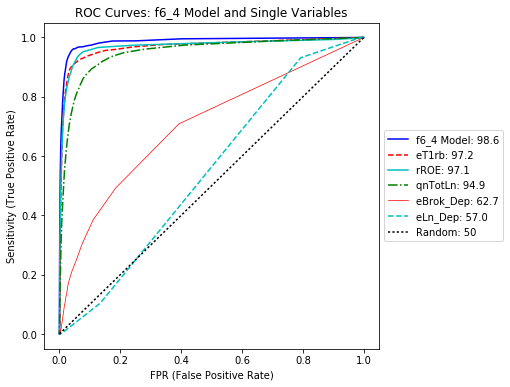

In [61]:
## Code to resize chart frame !!!!!!
#f6auc['aucs'] = f6auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f6auc['modvar'],f6auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f6roc['f6_4rr_FPR'],f6roc['f6_4rr_sens'],c='b',lw=1.5,label=('f6_4 Model: '+dauc['f6_4rr']))
#plt.plot(f6roc['f6_1_FPR'],f6roc['f6_1_sens'],c='b',ls='--',label='f6_1: '+dauc['f6_1'])
plt.plot(f6roc['f6_eT1rb_FPR'],f6roc['f6_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f6_eT1rb'])
plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',ls='-',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_qnTotLn_FPR'],f6roc['f6_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f6_qnTotLn'])
#plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_eBrok_Dep_FPR'],f6roc['f6_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f6_eBrok_Dep'])
plt.plot(f6roc['f6_eLn_Dep_FPR'],f6roc['f6_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f6_eLn_Dep'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f6_4 Model and Single Variables')
plt.savefig('ROC_f6_roe0mm2_2009.png', dpi=300, bbox_inches='tight')
plt.show()

In [62]:
#f2roc:
for i in np.arange(len(f2lst)):
#for i in np.arange(2):
  v = f2lst[i]
  y = roc(dffg, 'f2', v, ctlst)
  if i == 0:
    f2roc = y[['cut','sens','FPR']]
    f2roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f2roc = f2roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f2roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f2roc.to_csv("f2rocpts_roe0mm2_2009.csv")
f2roc.head()    

cut  f2_0rr_sens  f2_0rr_FPR  f2_1rr_sens  f2_1rr_FPR  f2_rROA_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000      1.000000   
1  0.001     0.980456    0.060401     0.978827    0.069762      0.988599   
2  0.002     0.978827    0.039575     0.975570    0.042596      0.929967   
3  0.003     0.977199    0.032155     0.973941    0.033801      0.762215   
4  0.004     0.969055    0.028068     0.970684    0.028994      0.605863   

   f2_rROA_FPR  f2_eT1rb_sens  f2_eT1rb_FPR  f2_qnTotLn_sens  f2_qnTotLn_FPR  \
0     1.000000       1.000000      1.000000         1.000000        1.000000   
1     0.612280       0.975570      0.068237         0.990228        0.659678   
2     0.049357       0.972313      0.038836         0.921824        0.099752   
3     0.022551       0.964169      0.029747         0.840391        0.046444   
4     0.013284       0.956026      0.026189         0.737785        0.029499   

   f2_eBrok_Dep_sens  f2_eBrok_Dep_FPR  f2_lnTotAst_sens  f2_lnTotAst_FPR  \
0           1.000000          1.000000          1.000000         1.000000   
1           0.649837          0.370850          0.785016         0.720897   
2           0.184039          0.049937          0.201954         0.167554   
3           0.105863          0.022069          0.076547         0.058096   
4           0.065147          0.013676          0.030945         0.031136   

   f2_rROE_sens  f2_rROE_FPR  f2_eLn_Dep_sens  f2_eLn_Dep_FPR  
0      1.000000     1.000000              1.0        1.000000  
1      0.975570     0.077262              1.0        1.000000  
2      0.969055     0.039276              0.0        0.001094  
3      0.956026     0.029293              0.0        0.000421  
4      0.951140     0.024131              0.0        0.000262

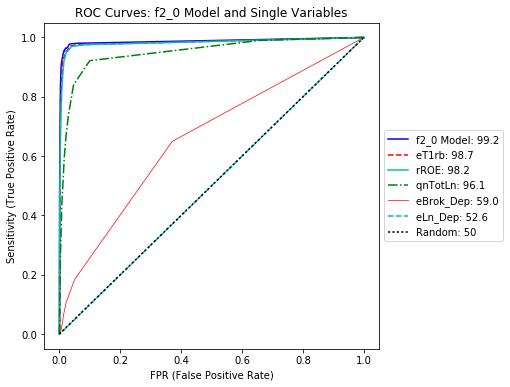

In [63]:
## Code to resize chart frame !!!!!!
#f2auc['aucs'] = f2auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f2auc['modvar'],f2auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f2roc['f2_0rr_FPR'],f2roc['f2_0rr_sens'],c='b',lw=1.5,label=('f2_0 Model: '+dauc['f2_0rr']))
#plt.plot(f2roc['f2_1_FPR'],f2roc['f2_1_sens'],c='b',ls='--',label='f2_1: '+dauc['f2_1'])
plt.plot(f2roc['f2_eT1rb_FPR'],f2roc['f2_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f2_eT1rb'])
plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',ls='-',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_qnTotLn_FPR'],f2roc['f2_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f2_qnTotLn'])
#plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_eBrok_Dep_FPR'],f2roc['f2_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f2_eBrok_Dep'])
plt.plot(f2roc['f2_eLn_Dep_FPR'],f2roc['f2_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f2_eLn_Dep'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f2_0 Model and Single Variables')
plt.savefig('ROC_f2_roe0mm2_2009.png', dpi=300, bbox_inches='tight')
plt.show()

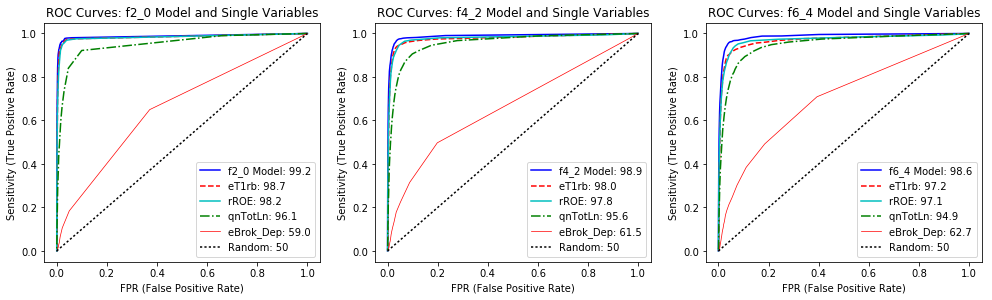

In [64]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.8, plSize[1]*1.1) )  ## double width, single height

plt.subplot(1, 3, 1)
dauc= dict(zip(f2auc['modvar'],f2auc['aucs']))

params = plt.gcf()
plt.plot(f2roc['f2_0rr_FPR'],f2roc['f2_0rr_sens'],c='b',lw=1.5,label=('f2_0 Model: '+dauc['f2_0rr']))
#plt.plot(f2roc['f2_1_FPR'],f2roc['f2_1_sens'],c='b',ls='--',label='f2_1: '+dauc['f2_1'])
plt.plot(f2roc['f2_eT1rb_FPR'],f2roc['f2_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f2_eT1rb'])
plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',ls='-',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_qnTotLn_FPR'],f2roc['f2_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f2_qnTotLn'])
#plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_eBrok_Dep_FPR'],f2roc['f2_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f2_eBrok_Dep'])
#plt.plot(f2roc['f2_eLn_Dep_FPR'],f2roc['f2_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f2_eLn_Dep'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4, fontsize=10)
plt.title('ROC Curves: f2_0 Model and Single Variables')

plt.subplot(1, 3, 2)
dauc= dict(zip(f4auc['modvar'],f4auc['aucs']))

params = plt.gcf()
plt.plot(f4roc['f4_2rr_FPR'],f4roc['f4_2rr_sens'],c='b',lw=1.5,label='f4_2 Model: '+dauc['f4_2rr'])
#plt.plot(f4roc['f4_3rr_FPR'],f4roc['f4_3rr_sens'],c='b',ls='--',label='f4 Model2: '+dauc['f4_3rr'])
plt.plot(f4roc['f4_eT1rb_FPR'],f4roc['f4_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f4_eT1rb'])
#plt.plot(f4roc['f4_rROA_FPR'],f4roc['f4_rROA_sens'],c='c',ls='--',label='rROA: '+dauc['f4_rROA'])
plt.plot(f4roc['f4_rROE_FPR'],f4roc['f4_rROE_sens'],c='c',label='rROE: '+dauc['f4_rROE'])
plt.plot(f4roc['f4_qnTotLn_FPR'],f4roc['f4_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f4_qnTotLn'])
plt.plot(f4roc['f4_eBrok_Dep_FPR'],f4roc['f4_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f4_eBrok_Dep'])
#plt.plot(f4roc['f4_eLn_Dep_FPR'],f4roc['f4_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f4_eLn_Dep'])
#plt.plot(f4roc['f4_aFF_TA_FPR'],f4roc['f4_aFF_TA_sens'],c='g',ls='--',label='aFF_TA: '+dauc['f4_aFF_TA'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4,fontsize=10)
plt.title('ROC Curves: f4_2 Model and Single Variables')

plt.subplot(1, 3, 3)
dauc= dict(zip(f6auc['modvar'],f6auc['aucs']))

params = plt.gcf()
plt.plot(f6roc['f6_4rr_FPR'],f6roc['f6_4rr_sens'],c='b',lw=1.5,label=('f6_4 Model: '+dauc['f6_4rr']))
#plt.plot(f6roc['f6_1_FPR'],f6roc['f6_1_sens'],c='b',ls='--',label='f6_1: '+dauc['f6_1'])
plt.plot(f6roc['f6_eT1rb_FPR'],f6roc['f6_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f6_eT1rb'])
plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',ls='-',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_qnTotLn_FPR'],f6roc['f6_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f6_qnTotLn'])
#plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_eBrok_Dep_FPR'],f6roc['f6_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f6_eBrok_Dep'])
#plt.plot(f6roc['f6_eLn_Dep_FPR'],f6roc['f6_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f6_eLn_Dep'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4, fontsize=10)
plt.title('ROC Curves: f6_4 Model and Single Variables')

plt.savefig('ROC_f246_roe0mm2_2009.png', dpi=400, bbox_inches='tight')
plt.show()

In [65]:
## identify optimal cut-off point

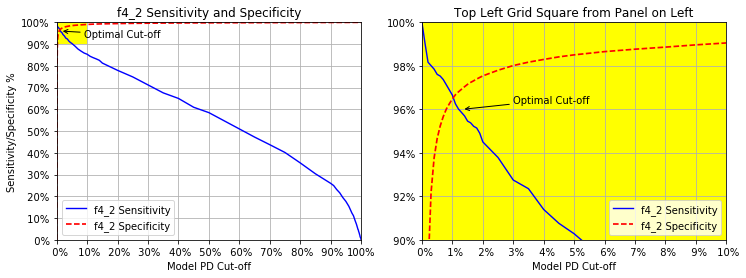

In [66]:
from matplotlib.patches import Rectangle

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.09, .93),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f4_2 Sensitivity and Specificity')
plt.grid('on')


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=0)

plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.03, .963),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid('on')
plt.savefig('SensSpecOptCut_f4_2_roe0mm2_2009.png', dpi=400, bbox_inches='tight')
plt.show()

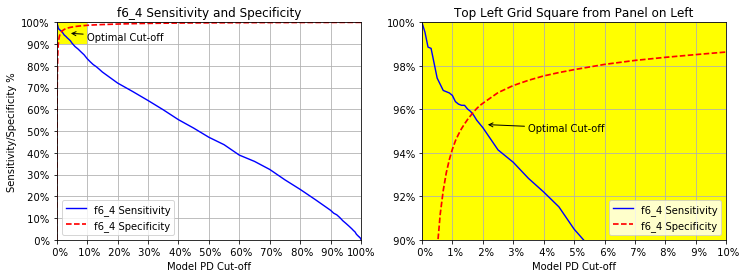

In [67]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.annotate('Optimal Cut-off', xy=(.04,.95), xytext=(.1, .92),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f6_4 Sensitivity and Specificity')
plt.grid('on')


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.021,.953), xytext=(.035, .95),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid('on')
plt.savefig('SensSpecOptCut_f6_4_roe0mm2_2009.png', dpi=400, bbox_inches='tight')
plt.show()

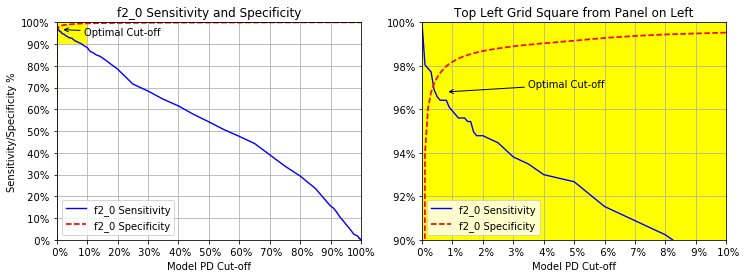

In [68]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.annotate('Optimal Cut-off', xy=(.015,.967), xytext=(.09, .94),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f2_0 Sensitivity and Specificity')
plt.grid('on')


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=0)

plt.annotate('Optimal Cut-off', xy=(.008,.968), xytext=(.035, .97),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid('on')

plt.savefig('SensSpecOptCut_f2_0_roe0mm2_2009.png', dpi=400, bbox_inches='tight')
plt.show()


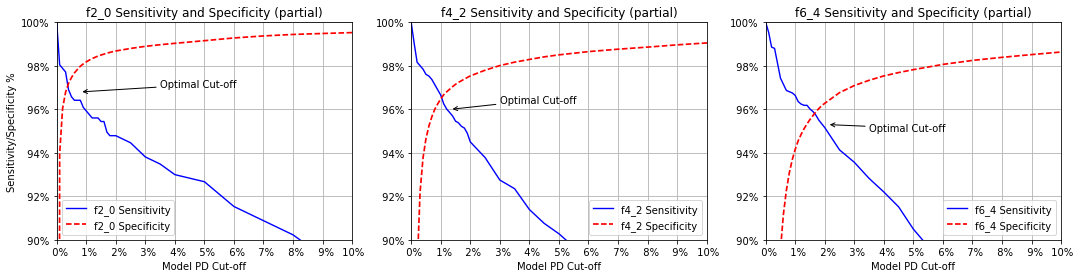

In [69]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 3, 1)
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.ylabel('Sensitivity/Specificity %')
plt.legend(loc=0)

plt.annotate('Optimal Cut-off', xy=(.008,.968), xytext=(.035, .97),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f2_0 Sensitivity and Specificity (partial)')
plt.grid('on')

plt.subplot(1, 3, 2)
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=0)

plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.03, .963),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f4_2 Sensitivity and Specificity (partial)')
plt.grid('on')

plt.subplot(1, 3, 3)
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.021,.953), xytext=(.035, .95),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f6_4 Sensitivity and Specificity (partial)')
plt.grid('on')

plt.savefig('SensSpecOptCut_f246partial_roe0mm2_2009.png', dpi=400, bbox_inches='tight')
plt.show()

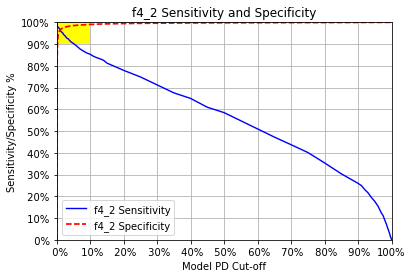

In [70]:
from matplotlib.patches import Rectangle
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.title('f4_2 Sensitivity and Specificity')
plt.grid('on')
plt.show()

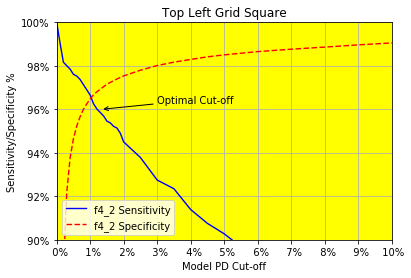

In [71]:
from matplotlib.patches import Rectangle
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.4,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=0)

plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.03, .963),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square')
plt.grid('on')
plt.show()

In [72]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
454780 2016-09-30   0   0   0   0  6.245865e-11  1.221664e-10  2.272020e-09   
454781 2016-12-31   0   0   0   0  6.240875e-09  1.053034e-08  1.175688e-07   

                f4_3          f6_4    ...      f6_lnTotAst   f2_rROE  \
454780  1.524872e-10  1.037877e-08    ...         0.003850  0.001036   
454781  1.665627e-08  4.160919e-07    ...         0.004208  0.000996   

         f4_rROE   f6_rROE  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  f2_aFF_TA  \
454780  0.003808  0.007748    0.001570    0.004053    0.006743   0.002157   
454781  0.003651  0.007442    0.001474    0.003763    0.006196   0.001950   

        f4_aFF_TA  f6_aFF_TA  
454780   0.004481   0.005553  
454781   0.004235   0.005569  

[2 rows x 41 columns]

In [73]:
#### section to process problem bank list 12/31/2010:
pbk = pd.read_csv('ProbBank20101231.csv',skiprows=3,encoding='latin1')
pbk['Date'] = pd.to_datetime(pbk['Date'])
pbk['Prompt Corrective Action Date'] = pd.to_datetime(pbk['Prompt Corrective Action Date'])

In [74]:
pbk.head()

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   
2        1149                 116962    SM    FRB   
3        3564                 319321     N    OCC   
4       57157                  83618    NM   FDIC   

                                 Name             City State       Date  \
0                   1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1   1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   
2                  1st Financial Bank    Overland Park    KS 2009-06-22   
3  1st National Bank of South Florida        Homestead    FL 2010-06-29   
4                    1st Regents Bank          Andover    MN 2010-03-24   

  Enforcement Action Type       Reason Prompt Corrective Action  \
0           Consent Order      Capital                      NaN   
1   Supervisory Agreement      General                      NaN   
2       Written Agreement      General                      NaN   
3           Consent Order  CRE lending                      NaN   
4           Consent Order       C&D RE                      NaN   

  Prompt Corrective Action Date Ticker Symbol  
0                           NaT           CBC  
1                           NaT           NaN  
2                           NaT           NaN  
3                           NaT           NaN  
4                           NaT           NaN

In [75]:
pbk['prob'] = 1
pbk.head()

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   
2        1149                 116962    SM    FRB   
3        3564                 319321     N    OCC   
4       57157                  83618    NM   FDIC   

                                 Name             City State       Date  \
0                   1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1   1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   
2                  1st Financial Bank    Overland Park    KS 2009-06-22   
3  1st National Bank of South Florida        Homestead    FL 2010-06-29   
4                    1st Regents Bank          Andover    MN 2010-03-24   

  Enforcement Action Type       Reason Prompt Corrective Action  \
0           Consent Order      Capital                      NaN   
1   Supervisory Agreement      General                      NaN   
2       Written Agreement      General                      NaN   
3           Consent Order  CRE lending                      NaN   
4           Consent Order       C&D RE                      NaN   

  Prompt Corrective Action Date Ticker Symbol  prob  
0                           NaT           CBC     1  
1                           NaT           NaN     1  
2                           NaT           NaN     1  
3                           NaT           NaN     1  
4                           NaT           NaN     1

In [76]:
rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult201612.csv", index_col=0)  # this version has top100 banks assigned to merger parents
rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])

In [77]:
pbk = pbk.merge(rk[['xCert','IDRSSD']],how='left',left_on='FDIC Cert#',right_on='xCert')
pbk.head(2)

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   

                                Name             City State       Date  \
0                  1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1  1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   

  Enforcement Action Type   Reason Prompt Corrective Action  \
0           Consent Order  Capital                      NaN   
1   Supervisory Agreement  General                      NaN   

  Prompt Corrective Action Date Ticker Symbol  prob    xCert     IDRSSD  
0                           NaT           CBC     1  58358.0  3465383.0  
1                           NaT           NaN     1  58773.0  3688678.0

In [78]:
dff10 = dff[dff['AsOf']=='2010-12-31']
dff10 = dff10.merge(pbk[['IDRSSD','prob']],how='left',on = 'IDRSSD')
dff10.head(2)

IDRSSD       AsOf                              Name State  eTotAst  \
0      37 2010-12-31            BANK OF HANCOCK COUNTY    GA  83515.0   
1     242 2010-12-31  FIRST COMMUNITY BANK XENIA-FLORA    IL  32756.0   

    rcTotLn   qnTotLn      rNIM     rPPNR      rROA ...    f2_rROE   f4_rROE  \
0  0.632531  3.814983  3.922807  1.097109  0.743125 ...   0.000522  0.001839   
1  0.055148  0.271248  4.003830  1.490713  1.555913 ...   0.000323  0.001107   

    f6_rROE  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  f2_aFF_TA  f4_aFF_TA  \
0  0.003858    0.001304    0.003255    0.005252   0.001325   0.003407   
1  0.002371    0.001451    0.003693    0.006064   0.001265   0.003319   

   f6_aFF_TA prob  
0   0.005631  NaN  
1   0.005638  NaN  

[2 rows x 64 columns]

In [79]:
dff10[['prob','f4','f4_2']].groupby('prob').sum()

f4       f4_2
prob               
1.0   67  82.364673

In [80]:
dff10['prob']=dff10['prob'].fillna(0)

In [81]:
dff10['decile'] = pd.qcut(dff10['f4_2'], 10, labels=False)
dff10[['f4_2','decile']].groupby('decile').mean()

f4_2
decile          
0       0.000001
1       0.000025
2       0.000092
3       0.000207
4       0.000372
5       0.000592
6       0.000898
7       0.001361
8       0.002583
9       0.146954

In [82]:
dff10['decile'] = pd.qcut(dff10['f4_2'], 10, labels=False)
dff10[['f4_2','decile']].groupby('decile').sum()

f4_2
decile            
0         0.000927
1         0.017528
2         0.063694
3         0.142616
4         0.256389
5         0.407888
6         0.619715
7         0.937461
8         1.782235
9       101.398506

In [83]:
dff10p = dff10[dff10['prob']==1]
dff10p['decile'] = pd.qcut(dff10p['f4_2'], 10, labels=False)
dff10p[['f4_2','decile']].groupby('decile').mean()

f4_2
decile          
0       0.000133
1       0.000549
2       0.001027
3       0.001760
4       0.002943
5       0.006380
6       0.015714
7       0.044024
8       0.192266
9       0.730739

In [84]:
dff10p[['f4_2','decile']].groupby('decile').sum()

f4_2
decile           
0        0.011070
1        0.045009
2        0.084196
3        0.144341
4        0.241354
5        0.523137
6        1.288523
7        3.609941
8       15.765795
9       60.651307

In [85]:
dff10p0 = dff10[dff10['prob']==0]
dff10p0['decile'] = pd.qcut(dff10p0['f4_2'], 10, labels=False)
dff10p0[['f4_2','decile']].groupby('decile').mean()

f4_2
decile              
0       9.344197e-07
1       1.838192e-05
2       7.078650e-05
3       1.616259e-04
4       2.930875e-04
5       4.786013e-04
6       7.137205e-04
7       1.056670e-03
8       1.651698e-03
9       3.381981e-02

In [86]:
dff10p0[['f4_2','decile']].groupby('decile').sum()

f4_2
decile           
0        0.000568
1        0.011158
2        0.043038
3        0.098107
4        0.178197
5        0.290511
6        0.433228
7        0.642455
8        1.002581
9       20.562444

In [87]:
#############################################################################
## NOTE:  try Worst 3% & 4% & 5% of f4 scores... 
#############################################################################

In [88]:
dq95 = dff[['AsOf','f2_0','f2_1','f4_2','f4_3','f6_4','f6_5']].groupby('AsOf').quantile(.95)
dq95.rename(columns={'f2_0':'w5_2_0','f2_1':'w5_2_1','f4_2':'w5_4_2','f4_3':'w5_4_3','f6_4':'w5_6_4',\
                     'f6_5':'w5_6_5'},inplace=True)
dq96 = dff[['AsOf','f2_0','f2_1','f4_2','f4_3','f6_4','f6_5']].groupby('AsOf').quantile(.96)
dq96.rename(columns={'f2_0':'w4_2_0','f2_1':'w4_2_1','f4_2':'w4_4_2','f4_3':'w4_4_3','f6_4':'w4_6_4',\
                     'f6_5':'w4_6_5'},inplace=True)
dq97 = dff[['AsOf','f2_0','f2_1','f4_2','f4_3','f6_4','f6_5']].groupby('AsOf').quantile(.97)
dq97.rename(columns={'f2_0':'w3_2_0','f2_1':'w3_2_1','f4_2':'w3_4_2','f4_3':'w3_4_3','f6_4':'w3_6_4',\
                      'f6_5':'w3_6_5'},inplace=True)
#dqt = dq97.merge(dq96,how='left',left_index=True,right_index=True)
#dqt = dqt.merge(dq95,how='left',left_index=True,right_index=True)
dqt = pd.concat([dq97,dq96,dq95], axis=1)
dqt.ix['2010':'2011']

w3_2_0    w3_2_1    w3_4_2    w3_4_3    w3_6_4    w3_6_5  \
AsOf                                                                     
2010-03-31  0.027354  0.028551  0.126171  0.110540  0.200424  0.216266   
2010-06-30  0.017170  0.017411  0.085625  0.076041  0.148118  0.167522   
2010-09-30  0.014585  0.015122  0.074316  0.064393  0.139097  0.145103   
2010-12-31  0.015847  0.017841  0.068594  0.072423  0.133591  0.129242   
2011-03-31  0.012826  0.014003  0.058012  0.057203  0.105363  0.119690   
2011-06-30  0.010134  0.011349  0.047856  0.046275  0.092701  0.100793   
2011-09-30  0.008905  0.009296  0.042446  0.039476  0.078127  0.086141   
2011-12-31  0.007653  0.008542  0.035631  0.040000  0.078700  0.073886   

              w4_2_0    w4_2_1    w4_4_2    w4_4_3    w4_6_4    w4_6_5  \
AsOf                                                                     
2010-03-31  0.011055  0.011666  0.054307  0.051964  0.109238  0.108579   
2010-06-30  0.007962  0.008836  0.040482  0.039194  0.081433  0.083263   
2010-09-30  0.007541  0.008297  0.036130  0.033655  0.077369  0.081188   
2010-12-31  0.008069  0.008437  0.035767  0.039571  0.079922  0.079431   
2011-03-31  0.005777  0.007130  0.028776  0.028302  0.058946  0.058215   
2011-06-30  0.005019  0.005597  0.024822  0.023763  0.051266  0.051698   
2011-09-30  0.003818  0.004243  0.017229  0.017260  0.038610  0.040265   
2011-12-31  0.003208  0.003668  0.015105  0.015948  0.036502  0.034298   

              w5_2_0    w5_2_1    w5_4_2    w5_4_3    w5_6_4    w5_6_5  
AsOf                                                                    
2010-03-31  0.006362  0.006931  0.031970  0.032176  0.068793  0.067631  
2010-06-30  0.004989  0.005397  0.024958  0.023843  0.056218  0.054371  
2010-09-30  0.004425  0.004989  0.022806  0.020417  0.049772  0.052091  
2010-12-31  0.004448  0.005154  0.021221  0.021469  0.051311  0.048934  
2011-03-31  0.003244  0.003656  0.016530  0.015927  0.037754  0.039080  
2011-06-30  0.002645  0.003052  0.012766  0.011826  0.028102  0.028788  
2011-09-30  0.002040  0.002417  0.010022  0.009989  0.023916  0.025288  
2011-12-31  0.001894  0.002250  0.008777  0.009103  0.021400  0.021319

In [89]:
### screen for high outliers:
dff[list(set(e for r in dv4[['v1','v2','v3','v4']].values for e in r))].max()
## screen for eT1rb < 200

rROA         370.554643
eT1rb        200.000000
qnTotLn      100.000000
eBrok_Dep    100.000000
lnTotAst      21.473973
rROE         974.428135
dtype: float64

In [90]:
### screen for low outliers:
dff[list(set(e for r in dv4[['v1','v2','v3','v4']].values for e in r))].min()
## screen for lnTotAst > 2

rROA         -76.973035
eT1rb          0.000000
qnTotLn        0.000000
eBrok_Dep      0.000000
lnTotAst       4.672829
rROE        -200.000000
dtype: float64

In [91]:
dffw = dff.merge(dqt,how='left',left_on='AsOf',right_index=True)
dffw['w2_0'] = (dffw['f2_0']>dffw['w5_2_0'])*1 + (dffw['f2_0']>dffw['w4_2_0'])*1 + (dffw['f2_0']>dffw['w3_2_0'])*1
dffw['w2_1'] = (dffw['f2_1']>dffw['w5_2_1'])*1 + (dffw['f2_1']>dffw['w4_2_1'])*1 + (dffw['f2_1']>dffw['w3_2_1'])*1
dffw['w4_2'] = (dffw['f4_2']>dffw['w5_4_2'])*1 + (dffw['f4_2']>dffw['w4_4_2'])*1 + (dffw['f4_2']>dffw['w3_4_2'])*1
dffw['w4_3'] = (dffw['f4_3']>dffw['w5_4_3'])*1 + (dffw['f4_3']>dffw['w4_4_3'])*1 + (dffw['f4_3']>dffw['w3_4_3'])*1
dffw['w6_4'] = (dffw['f6_4']>dffw['w5_6_4'])*1 + (dffw['f6_4']>dffw['w4_6_4'])*1 + (dffw['f6_4']>dffw['w3_6_4'])*1
dffw['w6_5'] = (dffw['f6_5']>dffw['w5_6_5'])*1 + (dffw['f6_5']>dffw['w4_6_5'])*1 + (dffw['f6_5']>dffw['w3_6_5'])*1
dffw.head(2)

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   

    qnTotLn      rNIM     rPPNR      rROA ...     w5_4_2    w5_4_3    w5_6_4  \
0  0.202341  4.771308  2.035791  1.366385 ...   0.002861  0.003399  0.006738   
1  0.199812  4.673793  1.952308  1.314604 ...   0.002859  0.003307  0.006732   

     w5_6_5  w2_0  w2_1  w4_2  w4_3  w6_4 w6_5  
0  0.005921     0     0     0     0     0    0  
1  0.005985     0     0     0     0     0    0  

[2 rows x 87 columns]

In [92]:
dffw[['IDRSSD','w4_2']].groupby('w4_2').count()

IDRSSD
w4_2        
0     422220
1       4446
2       4437
3      13367

In [93]:
dffw.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8', 'Intercept', 'f2_0', 'f2_1',
       'f4_2', 'f4_3', 'f6_4', 'f6_5', 'f2_0rr', 'f2_1rr', 'f4_2rr', 'f4_3rr',
       'f6_4rr', 'f6_5rr', 'f2_rROA', 'f4_rROA', 'f6_rROA', 'f2_eT1rb',
       'f4_eT1rb', 'f6_eT1rb', 'f2_qnTotLn', 'f4_qnTotLn', 'f6_qnTotLn',
       'f2_eBrok_Dep', 'f4_eBrok_Dep', 'f6_eBrok_Dep', 'f2_lnTotAst',
       'f4_lnTotAst', 'f6_lnTotAst', 'f2_rROE', 'f4_rROE', 'f6_rROE',
       'f2_eLn_Dep', 'f4_eLn_Dep', 'f6_eLn_Dep', 'f2_aFF_TA', 'f4_aFF_TA',
       'f6_aFF_TA', 'w3_2_0', 'w3_2_1', 'w3_4_2', 'w3_4_3', 'w3_6_4', 'w3_6_5',
       'w4_2_0', 'w4_2_1', 'w4_4_2', 'w4_4_3', 'w4_6_4', 'w4_6_5', 'w5_2_0',
       'w5_2_1', 'w5_4_2', 'w5_4_3', 'w5_6_4', 'w5_6_5', 'w2_0', 'w2_1',
       'w4_2', 'w4_3', 'w6_4', 'w6_5'

In [94]:
## cohorts for f2_0:
wdb95=dffw[dffw['w2_0']==0][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdb95.columns = pd.MultiIndex.from_product([[95],list(wdb95.columns)])
wdb96=dffw[dffw['w2_0']<=1][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[96],list(wdb96.columns)])
wdb97=dffw[dffw['w2_0']<=2][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdb97.columns = pd.MultiIndex.from_product([[97],list(wdb97.columns)])

wdw5=dffw[(dffw['w2_0']>=1)][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdw5.columns = pd.MultiIndex.from_product([[5],list(wdw5.columns)])
wdw4=dffw[(dffw['w2_0']>=2)][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[4],list(wdw4.columns)])
wdw3=dffw[(dffw['w2_0']==3)][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[3],list(wdw3.columns)])

wdb0 = pd.concat([wdb95,wdb96,wdb97,wdw5,wdw4,wdw3],axis=1)
wdb0=wdb0.swaplevel(0,1,axis=1)
wdb0.sort_index(axis=1,inplace=True)
wdb0['2010']

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2010-03-31  8.340102  7.782763  7.756657  6.620167  6.630999  6.625513   
2010-06-30  8.601359  8.415283  8.257866  6.670501  6.680593  6.692580   
2010-09-30  8.883625  8.457180  8.311497  6.881499  6.890341  6.893310   
2010-12-31  8.667266  8.109969  8.130300  7.653568  7.659384  7.646787   

            eALLL_Ln                                  ...          rROE  \
                  3         4         5         95    ...            5    
AsOf                                                  ...                 
2010-03-31  4.619680  4.318437  4.099838  1.706973    ...    -76.294695   
2010-06-30  4.162486  3.936316  4.009504  1.722717    ...    -70.223855   
2010-09-30  3.995845  3.797917  3.742011  1.750143    ...    -69.004076   
2010-12-31  4.398743  4.136308  3.992812  1.780094    ...    -62.248054   

                                           rcTotLn                      \
                  95        96        97        3         4         5    
AsOf                                                                     
2010-03-31  2.691461  2.257347  1.705976  4.892919  4.539698  4.262327   
2010-06-30  3.465814  3.132091  2.639511  4.569111  4.232755  3.971235   
2010-09-30  4.175565  3.771929  3.346905  4.407208  4.067646  3.940143   
2010-12-31  4.927549  4.554327  4.118692  3.849747  3.654225  3.467851   

                                          
                  95        96        97  
AsOf                                      
2010-03-31  0.881340  0.905244  0.931499  
2010-06-30  0.871497  0.893115  0.916871  
2010-09-30  0.851613  0.878520  0.900936  
2010-12-31  0.789147  0.809294  0.832587  

[4 rows x 96 columns]

In [95]:
## cohorts for f2_1:
wdb95=dffw[dffw['w2_1']==0][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdb95.columns = pd.MultiIndex.from_product([[95],list(wdb95.columns)])
wdb96=dffw[dffw['w2_1']<=1][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[96],list(wdb96.columns)])
wdb97=dffw[dffw['w2_1']<=2][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdb97.columns = pd.MultiIndex.from_product([[97],list(wdb97.columns)])

wdw5=dffw[(dffw['w2_1']>=1)][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdw5.columns = pd.MultiIndex.from_product([[5],list(wdw5.columns)])
wdw4=dffw[(dffw['w2_1']>=2)][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[4],list(wdw4.columns)])
wdw3=dffw[(dffw['w2_1']==3)][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[3],list(wdw3.columns)])

wdb1 = pd.concat([wdb95,wdb96,wdb97,wdw5,wdw4,wdw3],axis=1)
wdb1=wdb1.swaplevel(0,1,axis=1)
wdb1.sort_index(axis=1,inplace=True)
wdb1['2010']

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2010-03-31  7.984633  7.621766  7.374564  6.640304  6.637706  6.636531   
2010-06-30  8.620570  8.333749  7.456928  6.712713  6.683990  6.691985   
2010-09-30  8.636221  8.277832  7.845942  6.906047  6.897827  6.900975   
2010-12-31  8.761339  8.060886  7.798363  7.671046  7.661430  7.643877   

            eALLL_Ln                                  ...          rROE  \
                  3         4         5         95    ...            5    
AsOf                                                  ...                 
2010-03-31  4.642506  4.341718  4.143331  1.704681    ...    -76.267732   
2010-06-30  4.167234  4.205737  4.038439  1.721192    ...    -70.895975   
2010-09-30  3.985843  3.870239  3.734904  1.750518    ...    -69.029577   
2010-12-31  4.385311  4.174027  4.005522  1.779424    ...    -62.079575   

                                           rcTotLn                      \
                  95        96        97        3         4         5    
AsOf                                                                     
2010-03-31  2.690040  2.247504  1.729124  4.967566  4.565358  4.357375   
2010-06-30  3.501236  3.134101  2.647644  4.538535  4.272136  4.091220   
2010-09-30  4.176910  3.790710  3.354060  4.388966  4.157301  3.993886   
2010-12-31  4.918677  4.538876  4.121936  3.876548  3.669020  3.512067   

                                          
                  95        96        97  
AsOf                                      
2010-03-31  0.876331  0.904175  0.929185  
2010-06-30  0.865173  0.891474  0.917819  
2010-09-30  0.848779  0.874778  0.901501  
2010-12-31  0.786819  0.808677  0.831757  

[4 rows x 96 columns]

In [96]:
## cohorts for f4_2:
wdb95=dffw[dffw['w4_2']==0][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdb95.columns = pd.MultiIndex.from_product([[95],list(wdb95.columns)])
wdb96=dffw[dffw['w4_2']<=1][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[96],list(wdb96.columns)])
wdb97=dffw[dffw['w4_2']<=2][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdb97.columns = pd.MultiIndex.from_product([[97],list(wdb97.columns)])

wdw5=dffw[(dffw['w4_2']>=1)][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdw5.columns = pd.MultiIndex.from_product([[5],list(wdw5.columns)])
wdw4=dffw[(dffw['w4_2']>=2)][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[4],list(wdw4.columns)])
wdw3=dffw[(dffw['w4_2']==3)][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[3],list(wdw3.columns)])

wdb2 = pd.concat([wdb95,wdb96,wdb97,wdw5,wdw4,wdw3],axis=1)
wdb2=wdb2.swaplevel(0,1,axis=1)
wdb2.sort_index(axis=1,inplace=True)
wdb2['2010']

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2010-03-31  8.419114  7.745467  7.822961  6.616673  6.632553  6.623063   
2010-06-30  8.869183  8.560736  8.236198  6.671643  6.674534  6.684278   
2010-09-30  9.318379  8.796439  8.337878  6.880108  6.876180  6.879840   
2010-12-31  8.764414  8.122480  8.087194  7.655838  7.658862  7.643781   

            eALLL_Ln                                  ...          rROE  \
                  3         4         5         95    ...            5    
AsOf                                                  ...                 
2010-03-31  4.646426  4.329077  4.158095  1.703903    ...    -76.749809   
2010-06-30  4.533836  4.270876  4.076032  1.719211    ...    -70.427823   
2010-09-30  4.067200  3.900932  3.811396  1.746485    ...    -69.329225   
2010-12-31  4.462676  4.168902  4.019395  1.778694    ...    -62.367352   

                                           rcTotLn                      \
                  95        96        97        3         4         5    
AsOf                                                                     
2010-03-31  2.715446  2.265552  1.717239  4.921504  4.595067  4.414245   
2010-06-30  3.476563  3.112228  2.648858  4.609964  4.275687  4.075069   
2010-09-30  4.192709  3.798669  3.355933  4.484787  4.223497  3.968458   
2010-12-31  4.933830  4.570766  4.140061  3.895259  3.684492  3.530502   

                                          
                  95        96        97  
AsOf                                      
2010-03-31  0.873333  0.902937  0.930613  
2010-06-30  0.866024  0.891326  0.915604  
2010-09-30  0.850120  0.872015  0.898532  
2010-12-31  0.785848  0.808032  0.831178  

[4 rows x 96 columns]

In [97]:
## cohorts for f4_3:
wdb95=dffw[dffw['w4_3']==0][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdb95.columns = pd.MultiIndex.from_product([[95],list(wdb95.columns)])
wdb96=dffw[dffw['w4_3']<=1][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[96],list(wdb96.columns)])
wdb97=dffw[dffw['w4_3']<=2][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdb97.columns = pd.MultiIndex.from_product([[97],list(wdb97.columns)])

wdw5=dffw[(dffw['w4_3']>=1)][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdw5.columns = pd.MultiIndex.from_product([[5],list(wdw5.columns)])
wdw4=dffw[(dffw['w4_3']>=2)][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[4],list(wdw4.columns)])
wdw3=dffw[(dffw['w4_3']==3)][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[3],list(wdw3.columns)])

wdb3 = pd.concat([wdb95,wdb96,wdb97,wdw5,wdw4,wdw3],axis=1)
wdb3=wdb3.swaplevel(0,1,axis=1)
wdb3.sort_index(axis=1,inplace=True)
wdb3['2010']

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2010-03-31  8.380955  7.733294  7.651936  6.625686  6.633060  6.624246   
2010-06-30  8.801930  8.369975  8.191406  6.674004  6.682481  6.686363   
2010-09-30  8.853627  8.449098  8.067093  6.894386  6.890678  6.894239   
2010-12-31  8.705118  8.099438  7.969607  7.662030  7.659823  7.645616   

            eALLL_Ln                                  ...          rROE  \
                  3         4         5         95    ...            5    
AsOf                                                  ...                 
2010-03-31  4.635231  4.329952  4.131089  1.705326    ...    -76.471447   
2010-06-30  4.504043  4.247210  4.039575  1.721132    ...    -69.635041   
2010-09-30  4.013773  3.818221  3.729497  1.750803    ...    -68.506478   
2010-12-31  4.483435  4.141152  4.025384  1.778379    ...    -61.932020   

                                           rcTotLn                      \
                  95        96        97        3         4         5    
AsOf                                                                     
2010-03-31  2.700776  2.207802  1.668144  4.874728  4.556492  4.356783   
2010-06-30  3.434782  3.086241  2.600113  4.627039  4.275797  4.023649   
2010-09-30  4.149329  3.751271  3.290710  4.413826  4.084380  3.825450   
2010-12-31  4.910908  4.535848  4.117172  3.841650  3.618597  3.475328   

                                          
                  95        96        97  
AsOf                                      
2010-03-31  0.876362  0.904544  0.932063  
2010-06-30  0.868734  0.891322  0.915075  
2010-09-30  0.857660  0.877822  0.900730  
2010-12-31  0.788754  0.810779  0.832837  

[4 rows x 96 columns]

In [98]:
## cohorts for f6_4:
wdb95=dffw[dffw['w6_4']==0][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdb95.columns = pd.MultiIndex.from_product([[95],list(wdb95.columns)])
wdb96=dffw[dffw['w6_4']<=1][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[96],list(wdb96.columns)])
wdb97=dffw[dffw['w6_4']<=2][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdb97.columns = pd.MultiIndex.from_product([[97],list(wdb97.columns)])

wdw5=dffw[(dffw['w6_4']>=1)][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdw5.columns = pd.MultiIndex.from_product([[5],list(wdw5.columns)])
wdw4=dffw[(dffw['w6_4']>=2)][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[4],list(wdw4.columns)])
wdw3=dffw[(dffw['w6_4']==3)][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[3],list(wdw3.columns)])

wdb4 = pd.concat([wdb95,wdb96,wdb97,wdw5,wdw4,wdw3],axis=1)
wdb4=wdb4.swaplevel(0,1,axis=1)
wdb4.sort_index(axis=1,inplace=True)
wdb4['2010']

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2010-03-31  8.594799  7.832294  7.552504  6.630926  6.628935  6.617618   
2010-06-30  8.716676  8.304050  8.066161  6.680605  6.685227  6.689006   
2010-09-30  9.117271  8.800382  8.356078  6.879149  6.876015  6.886071   
2010-12-31  8.786357  8.146190  8.062845  7.657120  7.657874  7.643103   

            eALLL_Ln                                  ...          rROE  \
                  3         4         5         95    ...            5    
AsOf                                                  ...                 
2010-03-31  4.652188  4.391460  4.148270  1.704420    ...    -75.563511   
2010-06-30  4.544077  4.271005  4.021652  1.722077    ...    -69.278077   
2010-09-30  4.094743  3.953595  3.983400  1.737415    ...    -68.259124   
2010-12-31  4.490797  4.173395  4.034301  1.777909    ...    -61.969705   

                                           rcTotLn                      \
                  95        96        97        3         4         5    
AsOf                                                                     
2010-03-31  2.652927  2.220392  1.639919  4.952555  4.691957  4.381856   
2010-06-30  3.415969  3.054297  2.592402  4.639250  4.318826  4.026204   
2010-09-30  4.136286  3.758049  3.280059  4.465681  4.219998  4.050239   
2010-12-31  4.912892  4.513941  4.094819  3.839824  3.670476  3.561157   

                                          
                  95        96        97  
AsOf                                      
2010-03-31  0.875040  0.898901  0.929650  
2010-06-30  0.868600  0.889529  0.914697  
2010-09-30  0.845808  0.872161  0.899124  
2010-12-31  0.784234  0.808617  0.832894  

[4 rows x 96 columns]

In [99]:
## cohorts for f6_5:
wdb95=dffw[dffw['w6_5']==0][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdb95.columns = pd.MultiIndex.from_product([[95],list(wdb95.columns)])
wdb96=dffw[dffw['w6_5']<=1][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[96],list(wdb96.columns)])
wdb97=dffw[dffw['w6_5']<=2][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdb97.columns = pd.MultiIndex.from_product([[97],list(wdb97.columns)])

wdw5=dffw[(dffw['w6_5']>=1)][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdw5.columns = pd.MultiIndex.from_product([[5],list(wdw5.columns)])
wdw4=dffw[(dffw['w6_5']>=2)][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[4],list(wdw4.columns)])
wdw3=dffw[(dffw['w6_5']==3)][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[3],list(wdw3.columns)])

wdb5 = pd.concat([wdb95,wdb96,wdb97,wdw5,wdw4,wdw3],axis=1)
wdb5=wdb5.swaplevel(0,1,axis=1)
wdb5.sort_index(axis=1,inplace=True)
wdb5['2010']

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2010-03-31  8.422726  7.803588  7.673085  6.624571  6.630131  6.622951   
2010-06-30  8.695558  8.475148  8.171829  6.675036  6.678099  6.689660   
2010-09-30  9.298346  8.920457  8.501549  6.871479  6.871003  6.880461   
2010-12-31  8.711237  8.241367  8.137466  7.653191  7.653906  7.645427   

            eALLL_Ln                                  ...          rROE  \
                  3         4         5         95    ...            5    
AsOf                                                  ...                 
2010-03-31  4.657267  4.375045  4.151494  1.704251    ...    -76.138508   
2010-06-30  4.522235  4.286416  4.060145  1.720048    ...    -70.066378   
2010-09-30  4.101531  4.112967  3.982835  1.737445    ...    -68.397962   
2010-12-31  4.446350  4.188509  4.035343  1.777854    ...    -61.744762   

                                           rcTotLn                      \
                  95        96        97        3         4         5    
AsOf                                                                     
2010-03-31  2.683230  2.233668  1.677900  4.936924  4.719624  4.396851   
2010-06-30  3.457514  3.079288  2.612459  4.617008  4.285225  4.081322   
2010-09-30  4.143607  3.755356  3.308282  4.512240  4.331886  4.074925   
2010-12-31  4.901048  4.541024  4.108910  3.837429  3.736965  3.578839   

                                          
                  95        96        97  
AsOf                                      
2010-03-31  0.874250  0.897748  0.930135  
2010-06-30  0.865695  0.890929  0.915386  
2010-09-30  0.844506  0.867491  0.897681  
2010-12-31  0.783303  0.805845  0.832968  

[4 rows x 96 columns]

In [100]:
wdb2.columns.levels[0]

Index(['aFF_TA', 'eALLL_Ln', 'eBrok_Dep', 'eLn_Dep', 'eT1rb', 'eTotrb', 'f4',
       'f4_2', 'lnTotAst', 'qnTotLn', 'rEff', 'rNIM', 'rPPNR', 'rROA', 'rROE',
       'rcTotLn'],
      dtype='object')

In [101]:
wdb4.columns.levels[0]

Index(['aFF_TA', 'eALLL_Ln', 'eBrok_Dep', 'eLn_Dep', 'eT1rb', 'eTotrb', 'f6',
       'f6_4', 'lnTotAst', 'qnTotLn', 'rEff', 'rNIM', 'rPPNR', 'rROA', 'rROE',
       'rcTotLn'],
      dtype='object')

In [102]:
wg0 = wdb0.copy()
wg1 = wdb1.copy()
wg2 = wdb2.copy()
wg3 = wdb3.copy()
wg4 = wdb4.copy()
wg5 = wdb5.copy()
xg = list(wg2.index)

In [103]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  1.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  5.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

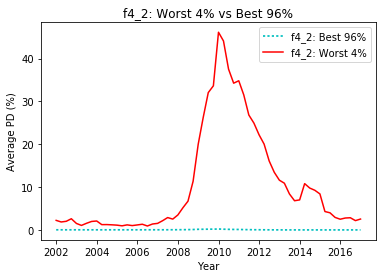

In [104]:
### f4_2 model:
xx2 = wg2['f4_2'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[96],c='c',ls=':',lw=1.7,label='f4_2: Best 96%')
plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: Worst 4% vs Best 96%')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
plt.xlabel('Year')
#plt.ylim([0,.1])
plt.savefig('f4_2_wrst4_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

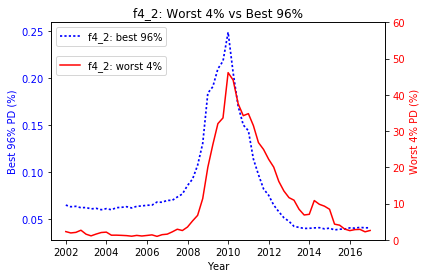

In [105]:
xx2 = wg2['f4_2'] * 100  # convert to units of %

ax1 = plt.gca()
ax1.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: best 96%')
ax1.set_ylabel('Best 96% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: worst 4%')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 4% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.8))

plt.title('f4_2: Worst 4% vs Best 96%')
ax1.set_xlabel('Year')
plt.show()

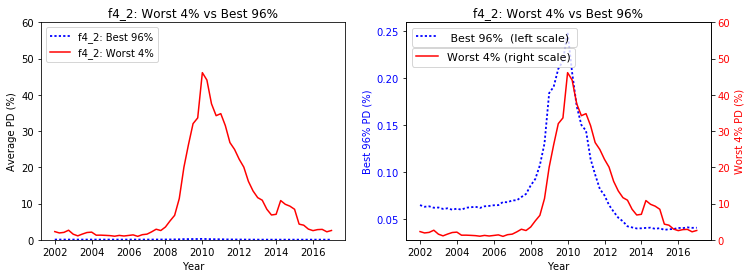

In [106]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
xx2 = wg2['f4_2'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[96],c='b',ls=':',lw=1.8,label='f4_2: Best 96%')
plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: Worst 4% vs Best 96%')
plt.legend(loc=2)
plt.ylim([0,60])
plt.ylabel('Average PD (%)')
plt.xlabel('Year')

plt.subplot(1, 2, 2)
ax1 = plt.gca()
ax1.plot(xg,xx2[96],c='b',ls=':',lw=1.8,label=' Best 96%  (left scale) ')
ax1.set_ylabel('Best 96% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2, fontsize=11)

ax2 = ax1.twinx()
ax2.plot(xg,xx2[4],c='r',lw=1.5,label='Worst 4% (right scale)')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 4% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.84), fontsize=11)

plt.title('f4_2: Worst 4% vs Best 96%')
ax1.set_xlabel('Year')

plt.savefig('f4_2_wrst4bst96_modpd_2charts.png', dpi=300, bbox_inches='tight')
plt.show()

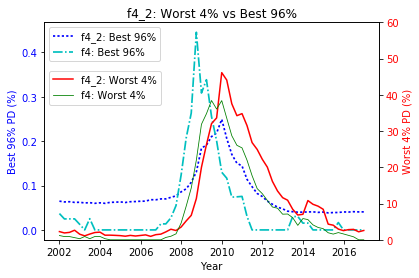

In [107]:
xx2 = wg2['f4_2'] * 100  # convert to units of %
aa2 = wg2['f4'] * 100

ax1 = plt.gca()
ax1.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: Best 96%')
ax1.plot(xg,aa2[96],c='c',ls='-.',lw=1.7,label='f4: Best 96%')
ax1.set_ylabel('Best 96% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
ax2.plot(xg,aa2[4],c='g',ls='-',lw=.8,label='f4: Worst 4%')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 4% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.7))

plt.title('f4_2: Worst 4% vs Best 96%')
ax1.set_xlabel('Year')
plt.show()

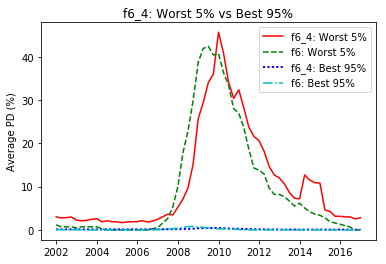

In [108]:
### f6_4 model:
xx4 = wg4['f6_4'] * 100  # convert to units of %
aa4 = wg4['f6'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx4[5],c='r',lw=1.5,label='f6_4: Worst 5%')
plt.plot(xg,aa4[5],c='g',ls='--',lw=1.5,label='f6: Worst 5%')
plt.plot(xg,xx4[95],c='b',ls=':',lw=1.9,label='f6_4: Best 95%')
plt.plot(xg,aa4[95],c='c',ls='-.',lw=1.5,label='f6: Best 95%')
plt.title('f6_4: Worst 5% vs Best 95%')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
#plt.ylim([0,.1])
plt.savefig('f6_4_wrst5_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

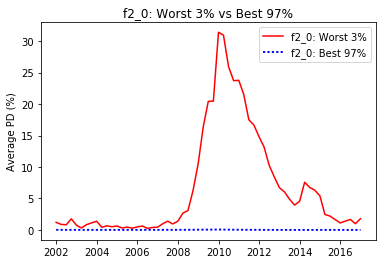

In [109]:
### f2_0 model:
xx0 = wg0['f2_0'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx0[3],c='r',lw=1.5,label='f2_0: Worst 3%')
plt.plot(xg,xx0[97],c='b',ls=':',lw=1.9,label='f2_0: Best 97%')
plt.title('f2_0: Worst 3% vs Best 97%')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
#plt.ylim([0,.1])
plt.savefig('f2_0_wrst3_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

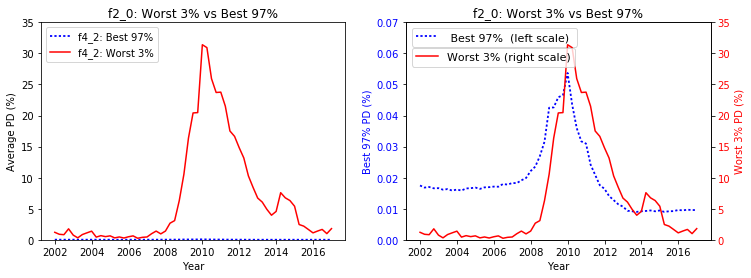

In [110]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
xx0 = wg0['f2_0'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx0[97],c='b',ls=':',lw=1.8,label='f4_2: Best 97%')
plt.plot(xg,xx0[3],c='r',lw=1.5,label='f4_2: Worst 3%')
plt.title('f2_0: Worst 3% vs Best 97%')
plt.legend(loc=2)
plt.ylim([0,35])
plt.ylabel('Average PD (%)')
plt.xlabel('Year')

plt.subplot(1, 2, 2)
ax1 = plt.gca()
ax1.plot(xg,xx0[96],c='b',ls=':',lw=1.8,label=' Best 97%  (left scale) ')
ax1.set_ylabel('Best 97% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_ylim([0,.07])
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2, fontsize=11)

ax2 = ax1.twinx()
ax2.plot(xg,xx0[3],c='r',lw=1.5,label='Worst 3% (right scale)')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 3% PD (%)',color='r')
ax2.set_ylim([0,35])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.84), fontsize=11)

plt.title('f2_0: Worst 3% vs Best 97%')
ax1.set_xlabel('Year')

plt.savefig('f2_0_wrst3bst97_modpd_2charts.png', dpi=300, bbox_inches='tight')
plt.show()

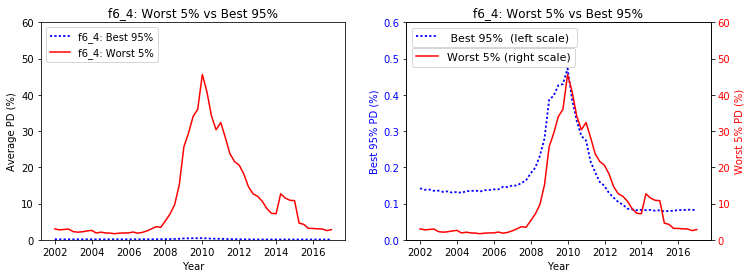

In [111]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
xx4 = wg4['f6_4'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx4[95],c='b',ls=':',lw=1.8,label='f6_4: Best 95%')
plt.plot(xg,xx4[5],c='r',lw=1.5,label='f6_4: Worst 5%')
plt.title('f6_4: Worst 5% vs Best 95%')
plt.legend(loc=2)
plt.ylim([0,60])
plt.ylabel('Average PD (%)')
plt.xlabel('Year')

plt.subplot(1, 2, 2)
ax1 = plt.gca()
ax1.plot(xg,xx4[95],c='b',ls=':',lw=1.8,label=' Best 95%  (left scale) ')
ax1.set_ylabel('Best 95% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_ylim([0,.6])
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2, fontsize=11)

ax2 = ax1.twinx()
ax2.plot(xg,xx4[5],c='r',lw=1.5,label='Worst 5% (right scale)')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 5% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.84), fontsize=11)

plt.title('f6_4: Worst 5% vs Best 95%')
ax1.set_xlabel('Year')

plt.savefig('f6_4_wrst5bst95_modpd_2charts.png', dpi=300, bbox_inches='tight')
plt.show()

In [112]:
xx2['2009':'2011']

3          4          5         95        96        97
AsOf                                                                     
2009-03-31  33.671499  26.260184  21.522870  0.165966  0.191085  0.230683
2009-06-30  40.932031  32.053189  26.264883  0.177768  0.210210  0.261082
2009-09-30  42.497318  33.634884  27.691746  0.178382  0.218345  0.284282
2009-12-31  58.232655  46.124920  37.923090  0.199272  0.249162  0.345646
2010-03-31  55.892026  44.086361  36.044784  0.164814  0.206106  0.289335
2010-06-30  48.018697  37.532044  30.611889  0.138858  0.170193  0.227534
2010-09-30  43.963667  34.250082  27.971335  0.121731  0.150267  0.201482
2010-12-31  44.738835  34.812992  28.426478  0.115318  0.144134  0.194583
2011-03-31  40.620231  31.516449  25.590479  0.092353  0.113968  0.154629
2011-06-30  34.662990  26.832497  21.860650  0.080108  0.097360  0.132198
2011-09-30  32.299890  24.934216  20.239109  0.068347  0.082083  0.109319
2011-12-31  28.864033  22.222167  17.993724  0.063958  0.075262  0.099318

In [113]:
xx4['2009':'2011']

3          4          5         95        96        97
AsOf                                                                     
2009-03-31  43.599132  35.127256  29.371837  0.397834  0.459934  0.555458
2009-06-30  50.167716  40.587592  33.997138  0.426197  0.503748  0.617328
2009-09-30  51.956737  42.684412  36.006177  0.429798  0.523425  0.665891
2009-12-31  66.135632  54.323705  45.639406  0.472532  0.579624  0.766170
2010-03-31  60.144964  48.939458  40.849991  0.386399  0.473768  0.622540
2010-06-30  51.023883  41.076609  34.160269  0.328124  0.394851  0.502894
2010-09-30  45.127633  36.417325  30.354673  0.286494  0.347202  0.449850
2010-12-31  48.375359  38.846893  32.354129  0.274215  0.337877  0.440229
2011-03-31  42.864024  34.159643  28.232485  0.216077  0.264171  0.342819
2011-06-30  35.960858  28.692455  23.744434  0.186646  0.223245  0.293474
2011-09-30  33.050152  26.196472  21.582565  0.159371  0.189528  0.244549
2011-12-31  31.596650  25.030698  20.575827  0.148853  0.176864  0.231330

In [114]:
wg2.columns.levels[0]

Index(['aFF_TA', 'eALLL_Ln', 'eBrok_Dep', 'eLn_Dep', 'eT1rb', 'eTotrb', 'f4',
       'f4_2', 'lnTotAst', 'qnTotLn', 'rEff', 'rNIM', 'rPPNR', 'rROA', 'rROE',
       'rcTotLn'],
      dtype='object')

In [115]:
wg0.to_csv("f2_0_vars_worst345best959697.csv")
wg1.to_csv("f2_1_vars_worst345best959697.csv")
wg2.to_csv("f4_2_vars_worst345best959697.csv")
wg3.to_csv("f4_3_vars_worst345best959697.csv")
wg4.to_csv("f6_4_vars_worst345best959697.csv")
wg5.to_csv("f6_5_vars_worst345best959697.csv")

In [116]:
dff.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8', 'Intercept', 'f2_0', 'f2_1',
       'f4_2', 'f4_3', 'f6_4', 'f6_5', 'f2_0rr', 'f2_1rr', 'f4_2rr', 'f4_3rr',
       'f6_4rr', 'f6_5rr', 'f2_rROA', 'f4_rROA', 'f6_rROA', 'f2_eT1rb',
       'f4_eT1rb', 'f6_eT1rb', 'f2_qnTotLn', 'f4_qnTotLn', 'f6_qnTotLn',
       'f2_eBrok_Dep', 'f4_eBrok_Dep', 'f6_eBrok_Dep', 'f2_lnTotAst',
       'f4_lnTotAst', 'f6_lnTotAst', 'f2_rROE', 'f4_rROE', 'f6_rROE',
       'f2_eLn_Dep', 'f4_eLn_Dep', 'f6_eLn_Dep', 'f2_aFF_TA', 'f4_aFF_TA',
       'f6_aFF_TA'],
      dtype='object')

In [117]:
len(dffw)

444470

In [118]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  1.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  5.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

In [119]:
wg2.head(2)

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2001-12-31  2.848934  2.564598  2.753582  6.038872  6.012492  5.968099   
2002-03-31  2.340755  2.270268  2.357334  5.576027  5.546204  5.510322   

            eALLL_Ln                                  ...         rROE  \
                  3         4         5         95    ...           5    
AsOf                                                  ...                
2001-12-31  2.554921  2.288416  2.124890  1.434007    ...    -1.361533   
2002-03-31  2.379108  2.143342  2.021753  1.464632    ...    -1.640128   

                                              rcTotLn                      \
                   95         96         97        3         4         5    
AsOf                                                                        
2001-12-31  10.329789  10.283842  10.223717  1.717500  1.486779  1.307646   
2002-03-31  10.473386  10.416629  10.360976  1.555254  1.325994  1.204497   

                                          
                  95        96        97  
AsOf                                      
2001-12-31  0.320764  0.323584  0.328446  
2002-03-31  0.312393  0.316599  0.319880  

[2 rows x 96 columns]

In [120]:
wg2.columns

MultiIndex(levels=[['aFF_TA', 'eALLL_Ln', 'eBrok_Dep', 'eLn_Dep', 'eT1rb', 'eTotrb', 'f4', 'f4_2', 'lnTotAst', 'qnTotLn', 'rEff', 'rNIM', 'rPPNR', 'rROA', 'rROE', 'rcTotLn'], [3, 4, 5, 95, 96, 97]],
           labels=[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15], [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]])

In [121]:
vlst=['eT1rb','rROE','qnTotLn','eBrok_Dep']
vdsc = ['Tier 1 Risk-Based Capital','Rolling 4q ROE', 'Non-Accrual Loans','Brokered Deposits']
vdct = dict(zip(vlst,vdsc))
vdct

{'eBrok_Dep': 'Brokered Deposits',
 'eT1rb': 'Tier 1 Risk-Based Capital',
 'qnTotLn': 'Non-Accrual Loans',
 'rROE': 'Rolling 4q ROE'}

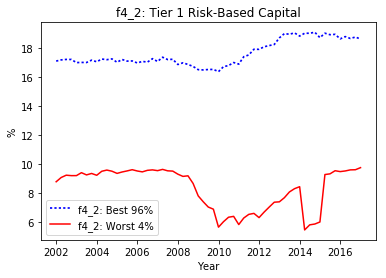

In [122]:
vc = 'eT1rb'
xx2 = wg2[vc] 
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: Best 96%')
plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: '+vdct[vc])
plt.legend(loc=0)
plt.ylabel('%')
plt.xlabel('Year')
#plt.ylim([0,.1])
plt.savefig('var_'+vc+'_wrst4.png', dpi=300, bbox_inches='tight')
plt.show()

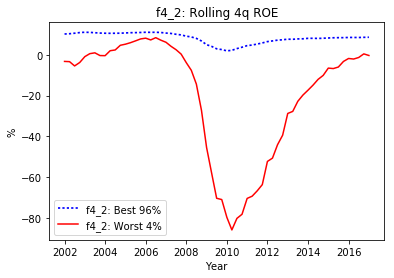

In [123]:
vc = 'rROE'
xx2 = wg2[vc]
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: Best 96%')
plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: '+vdct[vc])
plt.legend(loc=0)
plt.ylabel('%')
plt.xlabel('Year')
#plt.ylim([0,.1])
plt.savefig('var_'+vc+'_wrst4.png', dpi=300, bbox_inches='tight')
plt.show()

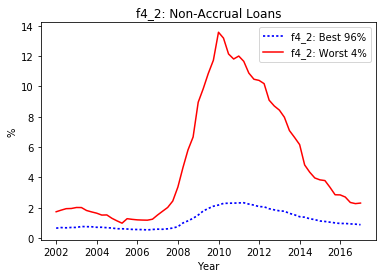

In [124]:
vc = 'qnTotLn'
xx2 = wg2[vc]
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: Best 96%')
plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: '+vdct[vc])
plt.legend(loc=0)
plt.ylabel('%')
plt.xlabel('Year')
#plt.ylim([0,.1])
plt.savefig('var_'+vc+'_wrst4.png', dpi=300, bbox_inches='tight')
plt.show()

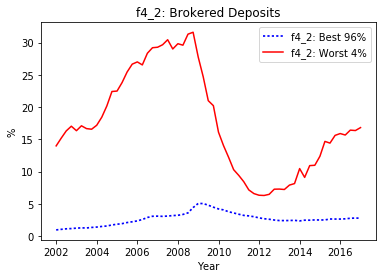

In [125]:
vc = 'eBrok_Dep'
xx2 = wg2[vc]
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: Best 96%')
plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: '+vdct[vc])
plt.legend(loc=0)
plt.ylabel('%')
plt.xlabel('Year')
#plt.ylim([0,.1])
plt.savefig('var_'+vc+'_wrst4.png', dpi=300, bbox_inches='tight')
plt.show()

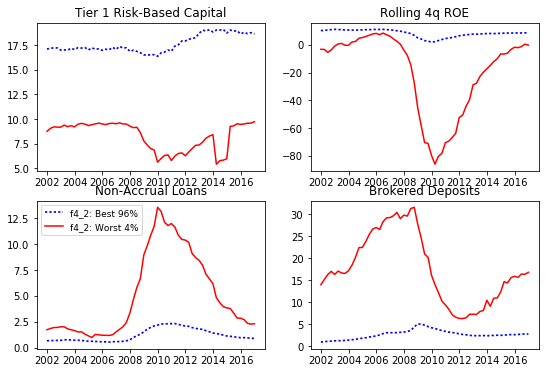

In [126]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1.5, plSize[1]*1.5) )  ## double width, single height

for i in np.arange(4):
  plt.subplot(2, 2, i+1)
  vc = vlst[i]
  xx2 = wg2[vc]
  plt.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: Best 96%')
  plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
  plt.title(vdct[vc])
  if i ==2: plt.legend(loc=0,fontsize=9)
  #plt.ylabel('%')
  #plt.xlabel('Year')


plt.savefig('f4_2_wrst4bst96_4var.png', dpi=300, bbox_inches='tight')
plt.show()